In [168]:
#libraries
import numpy as np
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



In [4]:
#general constants
g = 9.81
rocketDragCoef = 0.4
crossSectArea= 0.028
mInitial = 20
airBrakeCoeff = 2
airBrakeCrossSect = 0.015
rho_0 =  1.225
e = 2.718281828459045


In [13]:
#air density data
rawAirDensity = np.loadtxt(r"rocketData\air_density.csv", delimiter=',')  # Adjust skiprows based on your file's structure
airDensePoints = rawAirDensity.transpose()
#airDenseFunc = interpolate.CubicSpline(airDensePoints[0], airDensePoints[1])
a = 1.00367
b = -0.000101227
c = -0.000293537


def airDenseFunc(h):
    return a * e**(b*h)

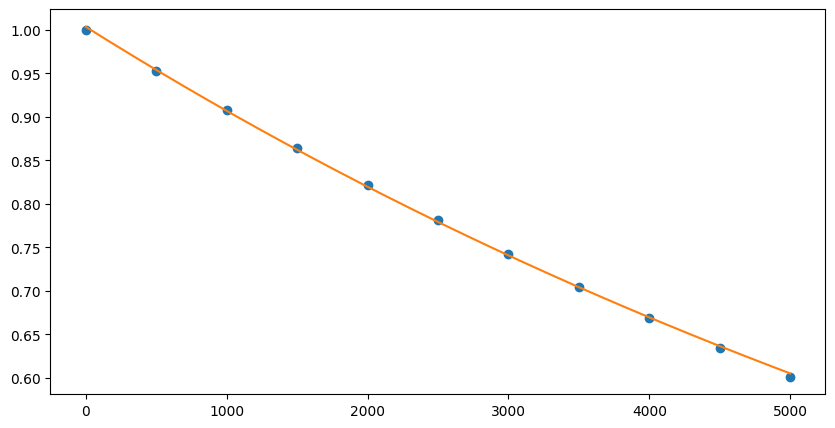

In [14]:
height =  np.linspace(0, 5000,5000)
sampleAirDensity = airDenseFunc(height)

plt.figure(figsize=(10,5))
plt.plot(airDensePoints[0], airDensePoints[1], 'o', label='Data Points')
plt.plot(height,sampleAirDensity)
plt.show()

In [15]:
#thrust data 
rawThrust = np.loadtxt(r'rocketData\thrust_curve.csv', delimiter=',')  # Adjust skiprows based on your file's structure
thrustPoints = rawThrust.transpose()
thrustFunc = interpolate.Akima1DInterpolator(thrustPoints[0], thrustPoints[1])

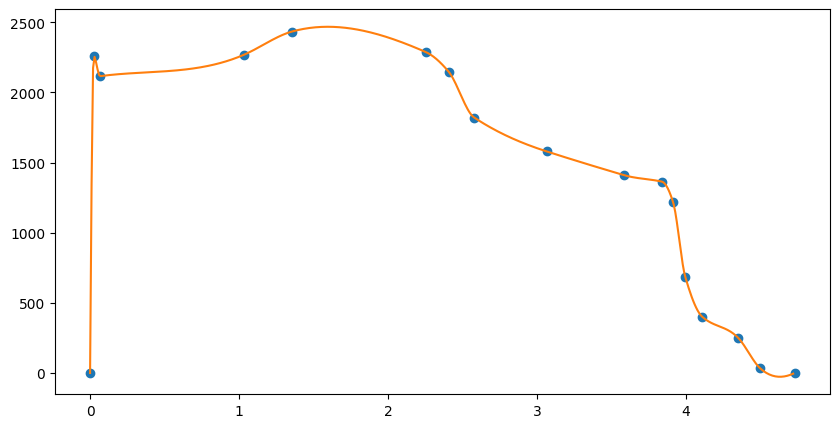

In [16]:
time =  np.linspace(0, 5, 500)
sampleThrust = thrustFunc(time)

plt.figure(figsize=(10,5))
plt.plot(thrustPoints[0], thrustPoints[1], 'o', label='Data Points')
plt.plot(time,sampleThrust)
plt.show()

In [17]:
#thrust curve 
def thrust(t):
    if t >= 0 and t <= 4.729:
        return thrustFunc(t)
    else:
        return 0 

In [19]:
#air density as a function of altitude 
def air_density(h):
    if (h >= 0 and h <= 5000):
        return rho_0 * airDenseFunc(h)
    
    elif():
        return

    else:
        return 0

In [20]:
def mass(t):
    burnRate = 3.717/4.5
    if t >= 0 and t <= 4.5:
        return mInitial - burnRate * t
    else:
        return mInitial - 3.717

In [21]:
#rocket drag given by velocity and height
def rocket_drag(v,h):
    rho = air_density(h)
    return 0.5 * rho * v**2 * rocketDragCoef * crossSectArea

In [22]:
def air_brake_drag(v,h,theta):
    rho = air_density(h)
    if 0 <= theta <= 1:
        return 0.5 * rho * v**2 * airBrakeCoeff * (airBrakeCrossSect * theta)
    else:
        return 0

In [23]:
def dynamic_equations(t,y,theta):
    h, v = y
    m = mass(t)
    T = thrust(t)
    D = rocket_drag(v, h)
    Dab= air_brake_drag(v,h,theta)
    dvdt = (T-D-Dab-m*g)/m
    dhdt = v

    return [dhdt, dvdt]


In [115]:
# PID control function
def pid_controller(Kp,Ki,Kd,setpoint, actual, prevError, integral, dt):
    error = setpoint - actual
    integral = error * dt
    derivative = (error - prevError)/dt
    output =  Kp * error + Ki * integral + Kd * derivative
    return output, error, integral

In [136]:
def simulation(Kp,Ki,Kd,desired_apogee):
    # Initial conditions
    y0 = [0, 0]  # initial altitude and velocity
    t_span = (0, 120)  # time span for the simulation

    integral = 0
    prevError = 0
    deployment = 0

    # Time points for output
    tPoints = np.linspace(t_span[0], t_span[1], 1200) 

    #the objective is to have 3 arrays with altitude with respect to time, velocity with respect to time and air brake deployment with respect to time
    # run the simulation with the PID control system
    altitude = []
    velocity = []
    deploymentVals = [] 
    for i in range(0,len(tPoints)):
        currentTime = tPoints[i]
        if i == 0:
            currentState = y0
            dt = tPoints[1]-tPoints[0]
        else:
            dt = tPoints[i] - tPoints[i-1]
            
        
        deployment, prevError, integral = pid_controller(Kp,Ki,Kd,desired_apogee,currentState[0], prevError, integral, dt)
        deployment = max(0,min(deployment, 1))

        #print(f"Time: {currentTime}, Deployment Length: {deployment}, Altitude: {currentState[0]}, Velocity: {currentState[1]}")
        

        solution = solve_ivp(dynamic_equations, [currentTime, currentTime + dt], currentState, args= (deployment,), t_eval= [currentTime + dt])

        currentState = np.array(solution.y[:,-1])

        # Set velocity to zero if altitude is zero or below
        if currentState[0] <= 0:
            currentState[0] = 0
            currentState[1] = 0

        # Store the results
        altitude.append(currentState[0])
        velocity.append(currentState[1])
        deploymentVals.append(deployment)

    return tPoints, altitude, velocity, deploymentVals


In [172]:
#simulation parameters
desired_apogee = 3000
Kp = 0.0001
Ki = 0.000002
Kd = 0.00000005
tPoints, altitude, velocity, deploymentVals = simulation(Kp,Ki,Kd,desired_apogee)

In [173]:
maxHeight = max(altitude)
maxVel = max(velocity)

print(maxHeight)
print(maxVel)

2366.838400918763
289.31517662779623


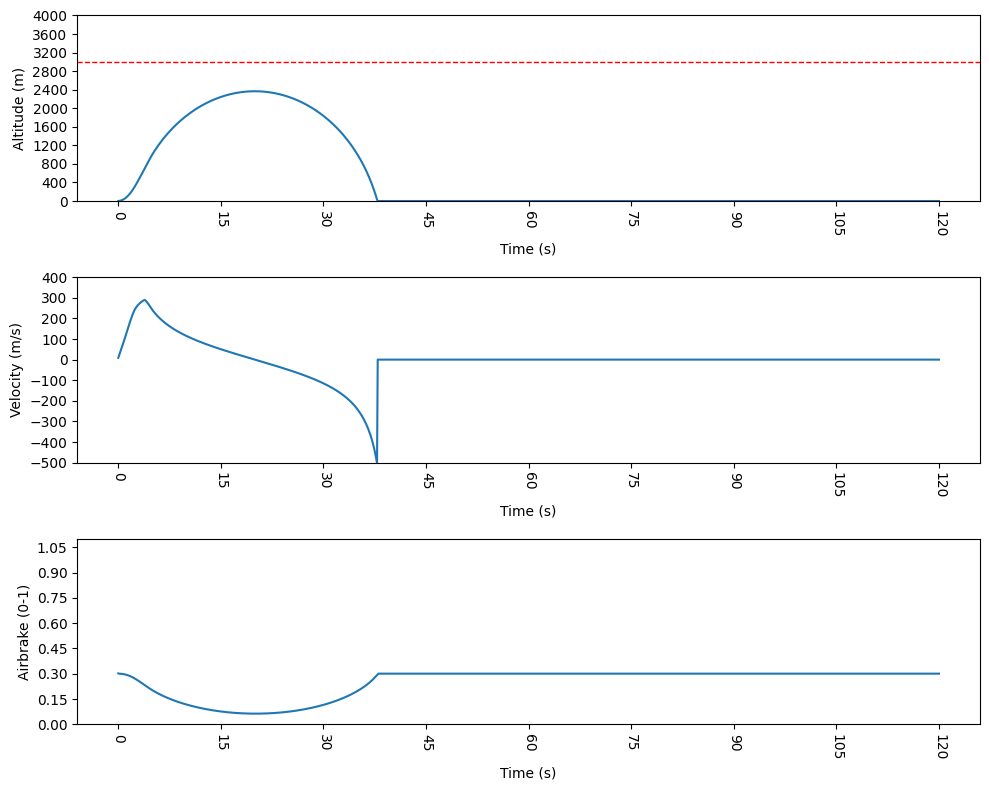

In [174]:
# Plotting results
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Altitude subplot
axs[0].plot(tPoints, altitude)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_ylim(0, 4000)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
axs[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
axs[0].tick_params(axis='x', rotation=-90)



#desired apogee
axs[0].axhline(y=desired_apogee, color='r', linestyle='--', linewidth=1)



# Velocity subplot
axs[1].plot(tPoints, velocity)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].set_ylim(-500, 400)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
axs[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
axs[1].tick_params(axis='x', rotation=-90)

# Airbrake deployment subplot
axs[2].plot(tPoints, deploymentVals)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Airbrake (0-1)')
axs[2].set_ylim(0, 1.1)
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
axs[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
axs[2].tick_params(axis='x', rotation=-90)

# Adjust layout to make room for x-axis labels
plt.tight_layout()

# Display the plot
plt.show()
